In [1]:
from ecnet.datasets import load_cn
from ecnet.tasks.feature_selection import select_rfr
from ecnet.tasks.parameter_tuning import tune_batch_size, tune_model_architecture,\
    tune_training_parameters
from ecnet import ECNet
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import median_absolute_error, r2_score
import torch
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from math import sqrt

In [2]:
dataset = load_cn(as_dataset=True, backend='alvadesc')
print(type(dataset), dataset.desc_vals.shape, dataset.target_vals.shape)

<class 'ecnet.datasets.structs.QSPRDatasetFromFile'> torch.Size([460, 5305]) torch.Size([460, 1])


In [3]:
index_train, index_test = train_test_split([i for i in range(len(dataset))],
                                           test_size=0.2, random_state=42)
dataset_train = deepcopy(dataset)
dataset_train.set_index(index_train)
dataset_test = deepcopy(dataset)
dataset_test.set_index(index_test)
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)

torch.Size([368, 5305]) torch.Size([92, 5305])


In [4]:
desc_idx, desc_imp = select_rfr(dataset_train, total_importance=0.95,
                                n_estimators=100, n_jobs=4)
dataset_train.set_desc_index(desc_idx)
dataset_test.set_desc_index(desc_idx)
desc_names = [dataset.desc_names[i] for i in desc_idx]
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)
print(desc_names[:5], len(desc_names))

torch.Size([368, 326]) torch.Size([92, 326])
['SpMaxA_EA(ed)', 'CIC1', 'S3K', 'SssCH2', 'PHI'] 326


In [5]:
model = ECNet(dataset_train.desc_vals.shape[1], 1, 128, 2)
train_loss, valid_loss = model.fit(
    dataset=dataset_train, valid_size=0.2,verbose=5,
    patience=50, epochs=300, random_state=24
)

Epoch: 0 | Train loss: 1431.029512781675 | Valid loss: 9223372036854775807
Epoch: 5 | Train loss: 256.55278923397975 | Valid loss: 312.9687194824219
Epoch: 10 | Train loss: 182.27286529541016 | Valid loss: 230.17494201660156
Epoch: 15 | Train loss: 153.28179630616896 | Valid loss: 207.3500518798828
Epoch: 20 | Train loss: 159.1366594794656 | Valid loss: 207.48974609375
Epoch: 25 | Train loss: 140.81340639283056 | Valid loss: 239.57949829101562
Epoch: 30 | Train loss: 98.12742137260177 | Valid loss: 148.23655700683594
Epoch: 35 | Train loss: 153.3734633517103 | Valid loss: 200.86534118652344
Epoch: 40 | Train loss: 109.15588352955929 | Valid loss: 141.3617706298828
Epoch: 45 | Train loss: 88.7531884122057 | Valid loss: 135.99325561523438
Epoch: 50 | Train loss: 95.22778156825474 | Valid loss: 199.7128143310547
Epoch: 55 | Train loss: 95.3749063712399 | Valid loss: 131.777099609375
Epoch: 60 | Train loss: 76.55440091762414 | Valid loss: 117.02298736572266
Epoch: 65 | Train loss: 69.95369

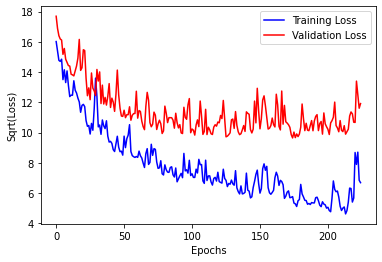

In [6]:
train_loss = [sqrt(l) for l in train_loss][5:]
valid_loss = [sqrt(l) for l in valid_loss][5:]
epoch = [i for i in range(len(train_loss))]
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Sqrt(Loss)')
plt.plot(epoch, train_loss, color='blue', label='Training Loss')
plt.plot(epoch, valid_loss, color='red', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [7]:
y_hat_train = model(dataset_train.desc_vals).detach().numpy()
y_train = dataset_train.target_vals
train_mae = median_absolute_error(y_hat_train, y_train)
train_r2 = r2_score(y_hat_train, y_train)
y_hat_test = model(dataset_test.desc_vals).detach().numpy()
y_test = dataset_test.target_vals
test_mae = median_absolute_error(y_hat_test, y_test)
test_r2 = r2_score(y_hat_test, y_test)
print('Training median absolute error: {}'.format(train_mae))
print('Training r-squared coefficient: {}'.format(train_r2))
print('Testing median absolute error: {}'.format(test_mae))
print('Testing r-squared coefficient: {}'.format(test_r2))

Training median absolute error: 3.772597312927246
Training r-squared coefficient: 0.8910070089699159
Testing median absolute error: 5.318617820739746
Testing r-squared coefficient: 0.779898764385632


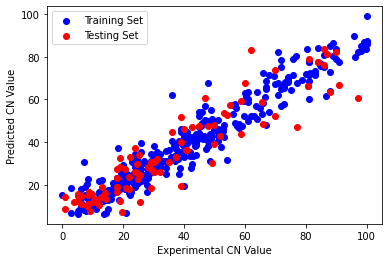

In [8]:
plt.clf()
plt.xlabel('Experimental CN Value')
plt.ylabel('Predicted CN Value')
plt.scatter(y_train, y_hat_train, color='blue', label='Training Set')
plt.scatter(y_test, y_hat_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()

In [9]:
test_maes = []
test_r2s = []
for _ in range(25):
    model = ECNet(dataset_train.desc_vals.shape[1], 1, 128, 2)
    model.fit(dataset=dataset_train, valid_size=0.2, patience=50, epochs=300, random_state=24)
    y_hat_test = model(dataset_test.desc_vals).detach().numpy()
    y_test = dataset_test.target_vals
    test_maes.append(median_absolute_error(y_hat_test, y_test))
    test_r2s.append(r2_score(y_hat_test, y_test))
print('Median median absolute error: {}'.format(np.median(test_maes)))
print('Median r-squared score: {}'.format(np.median(test_r2s)))

Median median absolute error: 5.252781867980957
Median r-squared score: 0.8107531026041015
